In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

In [2]:
pd.set_option('max_rows', 40)
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda number: '%.2f' % number)
from sklearn import set_config
#set_config(display='diagram') # unavailable for scikit-learn < 0.23

RANDOM_STATE = 42

# Load data

In [3]:
raw_data_train = pd.read_csv('../data/raw/train.csv')
raw_data_test = pd.read_csv('../data/raw/test.csv')

In [4]:
target_train = raw_data_train['y']
raw_data_train.drop('y', axis=1, inplace=True)

In [5]:
feature_groups = [
    [0, 1],
    [44, 43, 46, 62, 45, 13, 77, 61, 58, 4, 55, 56, 5, 75],
    [28, 26, 38, 37, 30, 31, 33, 34, 27, 29, 32, 36],
    [14, 23, 19, 20, 15, 24, 18],
    [2, 3, 17, 16, 39, 40, 21, 22, 25, 53, 69, 11, 12, 41, 42, 66, 76],
    [8, 70, 71, 10, 73, 74, 9, 6, 51, 52, 7, 49, 50, 63, 59, 60, 65],
    [57, 67, 68],
    [35, 48, 54],
    [72, 78, 47],
    [64],
]

**Explore feature groups**

In [6]:
feature_group_index = 1
raw_data_train.iloc[:, feature_groups[feature_group_index]].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
"Gross galactic product (GGP), total",1202.00,7749.98,7167.78,-933.22,5479.46,7130.47,8786.80,112391.32
Gross galactic product (GGP) per capita,1202.00,33338.26,18946.70,4007.14,21175.03,27952.62,40374.97,134636.65
Exports and imports (% of GGP),1144.00,133.44,53.01,18.99,101.38,125.73,154.89,477.06
"Remittances, inflows (% of GGP)",1028.00,11.93,9.02,-0.08,7.42,10.04,13.23,172.73
"Outer Galaxies direct investment, net inflows (% of GGP)",1169.00,18.34,15.38,-5.27,13.02,16.75,20.93,362.55
Gross capital formation (% of GGP),1502.00,31.86,8.48,2.49,27.18,31.22,36.03,72.31
Private galaxy capital flows (% of GGP),874.00,22.26,34.34,-735.19,17.23,24.47,31.75,95.94
Gross fixed capital formation (% of GGP),1074.00,29.94,7.64,6.13,25.47,29.42,33.55,75.08
Domestic credit provided by financial sector (% of GGP),1079.00,118.69,61.43,-38.30,78.54,104.42,145.76,555.80
Gross income per capita,3837.00,31633.24,18736.38,-126.91,20169.12,26600.77,36898.63,151072.68


# Build features

In [7]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

In [8]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.feature_extraction.text import CountVectorizer

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [10]:
initial_preprocessor = ColumnTransformer(
    [
        ('year', OrdinalEncoder(dtype='int'), ['galactic year']),
        
        ('galaxy', FeatureUnion(
            [
                ('onehot', OneHotEncoder(dtype='int')),
                ('bagofwords', Pipeline(
                    [
                        ('unravel', FunctionTransformer(lambda df: df.iloc[:, 0])),
                        ('vectorize', CountVectorizer(lowercase=True, binary=True, token_pattern=r'(?u)\b\S+\b')),
                    ])
                ),
            ],
            n_jobs=-1
        ), ['galaxy']),
        
    ],
    remainder='passthrough',
    n_jobs=-1,
    verbose=True,
    sparse_threshold=0
)

In [11]:
train_data_size = raw_data_train.shape[0]
num_original_features = raw_data_train.shape[1] - len(initial_preprocessor.transformers)

In [12]:
interim_features = initial_preprocessor.fit_transform(pd.concat([raw_data_train, raw_data_test], sort=False))

interim_features_train = interim_features[:train_data_size]
interim_features_test = interim_features[train_data_size:]

In [13]:
preprocessor = ColumnTransformer(
    [
        ('general', Pipeline(
            [
                ('imputer', IterativeImputer(initial_strategy='mean', imputation_order='ascending', random_state=RANDOM_STATE)),
                ('scaler', StandardScaler()),
            ],

            memory='../data/interim/',
            verbose=True,
        ), slice(-num_original_features, None))
    ],
    remainder='passthrough',
    n_jobs=-1,
    verbose=True
)

In [14]:
features_train = preprocessor.fit_transform(interim_features_train)
features_test = preprocessor.fit_transform(interim_features_test)

# Train models

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [16]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer

scoring_func = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

## Universal model

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
estimator = Pipeline(
    [
        ('preprocessor', preprocessor),
        #('feature_selector', SelectKBest(mutual_info_regression)),
        ('estimator', GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_STATE)),
    ],
    verbose=True
)

In [19]:
grid_search = GridSearchCV(
    estimator, 
    param_grid={
        #'feature_selector__k': range(10, 490, 10),
    }, 
    scoring=scoring_func,
    cv=5,
    n_jobs=-1, 
    verbose=6,
)

In [20]:
grid_search.fit(features_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.3s
[Pipeline] .. (step 2 of 3) Processing feature_selector, total= 1.4min
[Pipeline] ......... (step 3 of 3) Processing estimator, total=   2.7s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('general',
                                                                         Pipeline(memory='../data/interim/',
                                                                                  steps=[('imputer',
                                                                                          IterativeImputer(add_indicator=False,
                                                                                                           estimator=None,
  

In [21]:
print(grid_search.best_score_)

-0.032561213580010996


## Model per galaxy

In [22]:
models = {}

In [23]:
for i, galaxy_name in enumerate(raw_data_train['galaxy'].unique()):
    galaxy_index = (raw_data_train['galaxy'] == galaxy_name)
    galaxy_features = features_train[galaxy_index]
    galaxy_target = target_train[galaxy_index]
    models[galaxy_name] = GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE).fit(galaxy_features, galaxy_target)

# Generate predictions


## Universal model

In [24]:
predictions_train = grid_search.best_estimator_.predict(features_train)

In [25]:
mean_squared_error(target_train, predictions_train, squared=False)

0.018580009963442536

First try: 0.13000

After pipelining and bow: 0.06440

After iterative imputation: 0.01858

## Model per galaxy

In [26]:
predictions_train = np.empty(features_train.shape[0])

In [27]:
for i, galaxy_name in raw_data_train['galaxy'].iteritems():
    predictions_train[i] = models[galaxy_name].predict(features_train[i, :].reshape(1, -1))

In [28]:
mean_squared_error(target_train, predictions_train, squared=False)

0.0003091281607160787

First try: 0.00590

After pipelining and bow: 0.00030

After iterative imputation: no significant change

In [29]:
predictions_test = np.empty(features_test.shape[0])

In [30]:
for i, galaxy_name in raw_data_test['galaxy'].iteritems():
    predictions_test[i] = models[galaxy_name].predict(features_test[i, :].reshape(1, -1))

# Optimization problem

In [31]:
energy_allocations = raw_data_test[['galaxy', 'galactic year','existence expectancy index']]

Identify galaxies with top potential for increase in the index

In [32]:
index_increase_potential = (-np.log(predictions_test+0.01)+3)**2 / 1000

(array([  3.,  28.,  56.,  51.,  45.,  79., 148., 284., 177.,  19.]),
 array([0.01335274, 0.01612547, 0.01889819, 0.02167091, 0.02444364,
        0.02721636, 0.02998908, 0.03276181, 0.03553453, 0.03830725,
        0.04107998]),
 <a list of 10 Patch objects>)

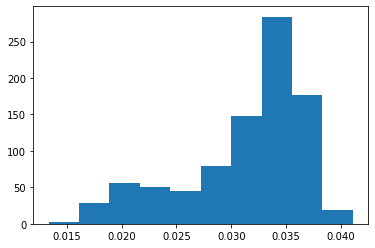

In [33]:
plt.hist(index_increase_potential)

In [34]:
top_indices = np.argsort(index_increase_potential)[-500:]

Allocate accordingly

In [35]:
TOTAL_AVAILABLE_ENERGY = 50000

In [36]:
energy_allocations['share'] = np.zeros(energy_allocations.shape[0])

/Users/hybris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
energy_allocations.loc[top_indices, 'share'] = 100

/Users/hybris/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [38]:
energy_allocations['share'].value_counts()

100.00    500
0.00      390
Name: share, dtype: int64

**Check allocations for validity**

In [39]:
GALAXY_ENERGY_MAX = 100
(energy_allocations['share'] > GALAXY_ENERGY_MAX).any()

False

In [40]:
GALAXY_ENERGY_MIN = 0
(energy_allocations['share'] < GALAXY_ENERGY_MIN).any()

False

In [41]:
energy_allocations['share'].sum() > TOTAL_AVAILABLE_ENERGY

False

In [42]:
EEI_THRESHOLD = 0.7
SUBSIDIZED_ENERGY_SHARE = 0.1

subsidized_galaxies = energy_allocations['existence expectancy index'] < EEI_THRESHOLD
energy_allocations.loc[subsidized_galaxies, ['share']].sum()['share'] < SUBSIDIZED_ENERGY_SHARE * TOTAL_AVAILABLE_ENERGY

False

# Export predictions

In [43]:
submitions_sample = pd.read_csv('../submitions/sample_submit.csv')
submitions = submitions_sample.copy(deep=True)

submitions['pred'] = predictions_test
submitions['opt_pred'] = energy_allocations['share']

In [44]:
submitions.to_csv(f'../submitions/submitions {datetime.datetime.now():%Y-%m-%dT%H-%M-%S}.csv', index=False)